# Vehicle Detection With Lane Lines

This is the combination of the last two projects, finding and annotating the lane lines with camera correction, and detecting the vehicles on the road.  The code below is simply the two of these projects combined.  Most of it is separate, but the resources that are used and the final classes from each project that assemble the final output are also combined.

## Combined Resources

In [1]:
import os
import math
import glob2
import numpy as np
import cv2
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from shapely.geometry import Polygon
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import *
from IPython.display import HTML
%matplotlib inline


## Lane Detection Code

In [2]:
class Image:
    
    def read_file(self, filename):
        image = cv2.imread(filename)
        self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.set_shape_gray()
        
    def set_image(self, image):
        self.image = image
        self.set_shape_gray()
        
    def set_shape_gray(self):
        self.shape = (self.image.shape[0], self.image.shape[1])
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        
    def undistort(self, cam_params):
        cam_matrix = cam_params[0]
        cam_dist = cam_params[1]
        self.image = cv2.undistort(self.image, cam_matrix, cam_dist, None, cam_matrix)
        self.set_shape_gray()
    
    def transform(self, old_points, new_points):
        src = np.array(old_points, np.float32)
        dst = np.array(new_points, np.float32)
        sx = self.shape[0]
        sy = self.shape[1]
        img_map = cv2.getPerspectiveTransform(src, dst)
        self.image = cv2.warpPerspective(self.image, img_map, (sy,sx), flags=cv2.INTER_LINEAR)
        self.set_shape_gray()

In [3]:
class Images:
    
    def __init__(self, directory):
        self.images = []
        filenames = os.listdir(directory)
        for filename in filenames:
            image = Image()
            image.read_file(directory + '/' + filename)
            self.images.append(image)

In [4]:
class Calibrate:
    
    def __init__(self, images, calibration_dimensions):
        self.images = images
        self.cal_dim = calibration_dimensions
        
    def image_points(self):
        image_points = []
        for i in range(len(self.images)):
            image = self.images[i]
            gray = image.gray
            self.img_dim = image.shape
            ret, corners = cv2.findChessboardCorners(gray, self.cal_dim, None)
            if ret == True:
                image_points.append(corners)
        return np.array(image_points, np.float32)
    
    def object_points(self, num_points):
        object_points = []
        temp = []
        for v in range(self.cal_dim[1]):
            for h in range(self.cal_dim[0]):
                temp.append([[h, v, 0]])
        for z in range(num_points):
            object_points.append(temp)
        return np.array(object_points, np.float32)
    
    def calibrate(self):
        img = self.image_points()
        obj = self.object_points(len(img))
        dim = (self.img_dim[1], self.img_dim[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj, img, dim, None, None)
        return (mtx, dist)

In [5]:
class Sobel:
    
    def __init__(self, image):
        self.image = image.gray
        
    def x(self):
        return cv2.Sobel(self.image, cv2.CV_64F, 1, 0)
    
    def y(self):
        return cv2.Sobel(self.image, cv2.CV_64F, 0, 1)
        
    def scale(self, image):
        scale = np.max(image) / 255
        return (image / scale).astype(np.uint8)
    
    def threshold(self, image, threshold_param):
        _, b = cv2.threshold(image, threshold_param[0], threshold_param[1], cv2.THRESH_BINARY)
        return b
    
    def mag_threshold(self, threshold_params):
        x = self.x()
        y = self.y()
        m = np.sqrt(x**2 + y**2)
        s = self.scale(m)
        return self.threshold(s, threshold_params)
        
    def dir_threshold(self, threshold_params):
        x = self.x() 
        y = self.y()
        with np.errstate(divide='ignore', invalid='ignore'):
            d = np.absolute(np.arctan(y / x))
            b = np.zeros_like(d)
            b[(d > threshold_params[0]) & (d < threshold_params[1])] = 1
        return b

In [6]:
class Color:
    
    def __init__(self, image):
        self.rgb = image.image
        self.hls = cv2.cvtColor(self.rgb, cv2.COLOR_RGB2HLS)
        
    def h(self, threshold_param):
        h = self.hls[:,:,0]
        _, b = cv2.threshold(h, threshold_param[0], threshold_param[1], cv2.THRESH_BINARY)
        return b
    
    def l(self, threshold_param):
        l = self.hls[:,:,1]
        _, b = cv2.threshold(l, threshold_param[0], threshold_param[1], cv2.THRESH_BINARY)
        return b
    
    def s(self, threshold_param):
        s = self.hls[:,:,2]
        _, b = cv2.threshold(s, threshold_param[0], threshold_param[1], cv2.THRESH_BINARY)
        return b

In [7]:
class Histogram:
    
    def __init__(self, image):
        self.image = image
        self.histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
        
    def add_image(self, image):
        self.image = image
        h = self.histogram
        h = np.add(h, np.sum(image[image.shape[0]/2:,:], axis=0))
        self.histogram = h
        
    def gaussian_histogram(self, center, scale):
        histogram = self.histogram
        for i, x in enumerate(histogram):
            diff1 = float(i) - float(center[0])
            result1 = math.exp(float(scale) * -math.fabs(diff1**2.0))
            diff2 = float(i) - float(center[1])
            result2 = math.exp(float(scale) * -math.fabs(diff2**2.0))
            histogram[i] = int(float(x) * (result1+result2))
        return histogram
        
    def peaks(self, threshold, histogram_range, gaussian_params):
        h = self.gaussian_histogram(gaussian_params[0], gaussian_params[1])
        h = h.reshape(-1,1)
        h = h[histogram_range[0]:histogram_range[1]]
        count = 0
        new = []
        for x in h:
            if x > threshold:
                new.append(count)
            count += 1
        h = np.array(new, np.float32)
        h = h.reshape(-1,1)
        km = KMeans(2)
        km.fit(h)
        values = km.cluster_centers_.squeeze()
        values = np.sort(np.array(values))
        values = [values[0] + histogram_range[0], values[1] + histogram_range[0]]
        return values
        
    def windowed_peaks(self, width, threshold, histogram_range, gaussian_params):
        p = self.peaks(threshold, histogram_range, gaussian_params)
        p1 = (int(p[0] - width), int(p[0] + width))
        p2 = (int(p[1] - width), int(p[1] + width))
        return (p1, p2)
        

In [8]:
class CurveTrack:
    
    def __init__(self, image):
        self.image = image
        
    def track(self, window, step):
        result = []
        r = (window[1] - window[0]) / 2
        s = self.image.shape
        for y in range(s[0]-1, step-1, -step):
            totalx = 0
            count = 0
            ys = y - step/2
            for x in range(window[0], window[1]):
                if self.image[y][x] > 0:
                    totalx = totalx + x
                    count += 1
            if count != 0:
                center = totalx / count
                window = (int(center - r), int(center + r))
                result.append((center, ys))
        return result

In [9]:
class CurveFit:
    
    def set_points(self, xs, ys):
        self.xs = xs
        self.ys = ys
        
    def set_coeffs(self, coeffs):
        self.fit = coeffs
    
    def fit_quadratic(self):
        self.fit = np.polyfit(self.ys, self.xs, 2)
    
    def estimate_point(self, y):
        return self.fit[0]*y**2 + self.fit[1]*y + self.fit[2]
        
    def compute_radius(self):
        y_max = np.max(self.ys)
        return ((1 + (2*self.fit[0]*y_max + self.fit[1])**2)**1.5) / np.absolute(2*self.fit[0])
        

In [10]:
class LaneFinder:
    
    def __init__(self, test_image_folder):
        self.test_image_folder = test_image_folder
        
    def calibrate(self, calibration_folder, calibration_size):
        self.images = Images(calibration_folder)
        cal = Calibrate(self.images.images, calibration_size)
        self.cam_cal = cal.calibrate()
     
    def load_image(self, filename):
        image = Image()
        image.read_file(self.test_image_folder + '/' + filename)
        self.image = image
        if hasattr(self.image, 'caml_cal'):
            self.image.undistort(self.cam_cal)
        
    def set_image(self, image):
        self.image.set_image(image)
        
    def set_video_image(self, image):
        self.image = image
        
    def save_image(self, filename):
        image = cv2.cvtColor(self.image.image, cv2.COLOR_BGR2RGB)
        cv2.imwrite(filename, image)
        
    def transform_image(self, source_points, dest_points):
        self.image.transform(source_points, dest_points)
        
    def get_image(self):
        return self.image.image
        
    def filter_image(self, color_threshold, sobel_mag_threshold, sobel_dir_threshold):
        color = Color(self.image)
        sobel = Sobel(self.image)
        l = color.l(color_threshold[1])
        s = color.s(color_threshold[2])
        m = sobel.mag_threshold(sobel_mag_threshold)
        d = sobel.dir_threshold(sobel_dir_threshold)
        r = np.multiply(l, s)
        r = np.multiply(r, d)
        return r
    
    def track_lane(self, image, window, step):
        c = CurveTrack(image)
        return c.track(window, step)
    
    def radius(self, points, which_radius):
        z = list(zip(*points))
        c = CurveFit()
        c.set_points(z[0], z[1])
        c.fit_quadratic()
        if which_radius == 'left':
            self.left_fit = c.fit
        if which_radius == 'right':
            self.right_fit = c.fit
        return c.compute_radius()
    
    def interpolate(self, image, points, y_range):
        z = list(zip(*points))
        c = CurveFit()
        c.set_points(z[0], z[1])
        c.fit_quadratic()
        result = []
        for y in range(y_range[0], y_range[1]):
            x = int(c.estimate_point(y))
            if x > 0 and x < image.shape[1]-1 and y > 0 and y < image.shape[0]-1:
                result.append((x,y))
        return result
    
    def interpolate_video(self, image, coeffs, y_range):
        result = []
        c = CurveFit()
        c.set_coeffs(coeffs)
        for y in range(y_range[0], y_range[1]):
            x = int(c.estimate_point(y))
            if x > 0 and x < image.shape[1]-1 and y > 0 and y < image.shape[0]-1:
                result.append((x,y))
        return result
    
    def apply_contours(self, line_data, left, right, y_range, original_shape):
        contour = []
        left_contour = np.array(self.interpolate(line_data, left, y_range), np.int32)
        left_size,_ = left_contour.shape
        right_contour = np.array(self.interpolate(line_data[::-1], right, y_range), np.int32)
        right_size,_ = right_contour.shape
        min_size = min(left_size, right_size)
        left_contour = left_contour[0:min_size]
        right_contour = right_contour[0:min_size]
        contour.append(left_contour)
        contour.append(right_contour[::-1])
        contour = np.array(contour, np.int32)
        contour = np.reshape(contour, (-1, 2))
        curve_overlay_image = np.zeros((original_shape[0], original_shape[1], 3), np.uint8)
        cv2.fillPoly(curve_overlay_image, [contour], color=(0,60,0))
        cv2.polylines(curve_overlay_image, [left_contour], False, (255,0,0), 30)
        cv2.polylines(curve_overlay_image, [right_contour], False, (255,0,0), 30)
        return curve_overlay_image
    
    def apply_contours_video(self, line_data, left_coeff, right_coeff, y_range, original_shape):
        contour = []
        left_contour = np.array(self.interpolate_video(line_data, left_coeff, y_range), np.int32)
        left_size,_ = left_contour.shape
        right_contour = np.array(self.interpolate_video(line_data[::-1], right_coeff, y_range), np.int32)
        right_size,_ = right_contour.shape
        min_size = min(left_size, right_size)
        left_contour = left_contour[0:min_size]
        right_contour = right_contour[0:min_size]
        contour.append(left_contour)
        contour.append(right_contour[::-1])
        contour = np.array(contour, np.int32)
        contour = np.reshape(contour, (-1, 2))
        curve_overlay_image = np.zeros((original_shape[0], original_shape[1], 3), np.uint8)
        cv2.fillPoly(curve_overlay_image, [contour], color=(0,60,0))
        cv2.polylines(curve_overlay_image, [left_contour], False, (255,0,0), 30)
        cv2.polylines(curve_overlay_image, [right_contour], False, (255,0,0), 30)
        return curve_overlay_image
    
    def apply_text(self, image, left_radius, right_radius, center_offset):
        font = cv2.FONT_HERSHEY_SIMPLEX
        left = '%.1fr' % left_radius
        cv2.putText(image, left, (25,700), font, 1, (255,255,255), 2)
        right = '%.1fr' % right_radius
        cv2.putText(image, right, (1130,700), font, 1, (255,255,255), 2)
        center = '%.2fm' % center_offset
        cv2.putText(image, center, (600,700), font, 1, (255,255,255), 2)


In [11]:
calibration_directory = 'camera_cal'
calibration_geometry  = (9,5)

camera_coordinates    = [[750,450], [1280,600], [0,600], [550,450]]
birds_eye_coordinates = [[1180,100],  [1180,620], [100,620], [100,100]]

color_threshold       = [(150,220), (120,250), (50,250)] 
sobel_mag_threshold   = (100, 250)
sobel_dir_threshold   = (0.2, 0.9)  

gaussian_params       = ((500, 800), 0.00001) 
histogram_valid_range = (300, 980)
windowed_peaks_arg    = (100, 50)  # width, threshold

y_range_curve_mapped  = (250, 710)
vertical_track_width  = 10

lane_center_location  = 640
lane_center_scale     = 0.004  # pixels / meter

video_average_frames  = 10
curve_threshold       = (1.0e-03, 1.0e0, 1.2e+02)


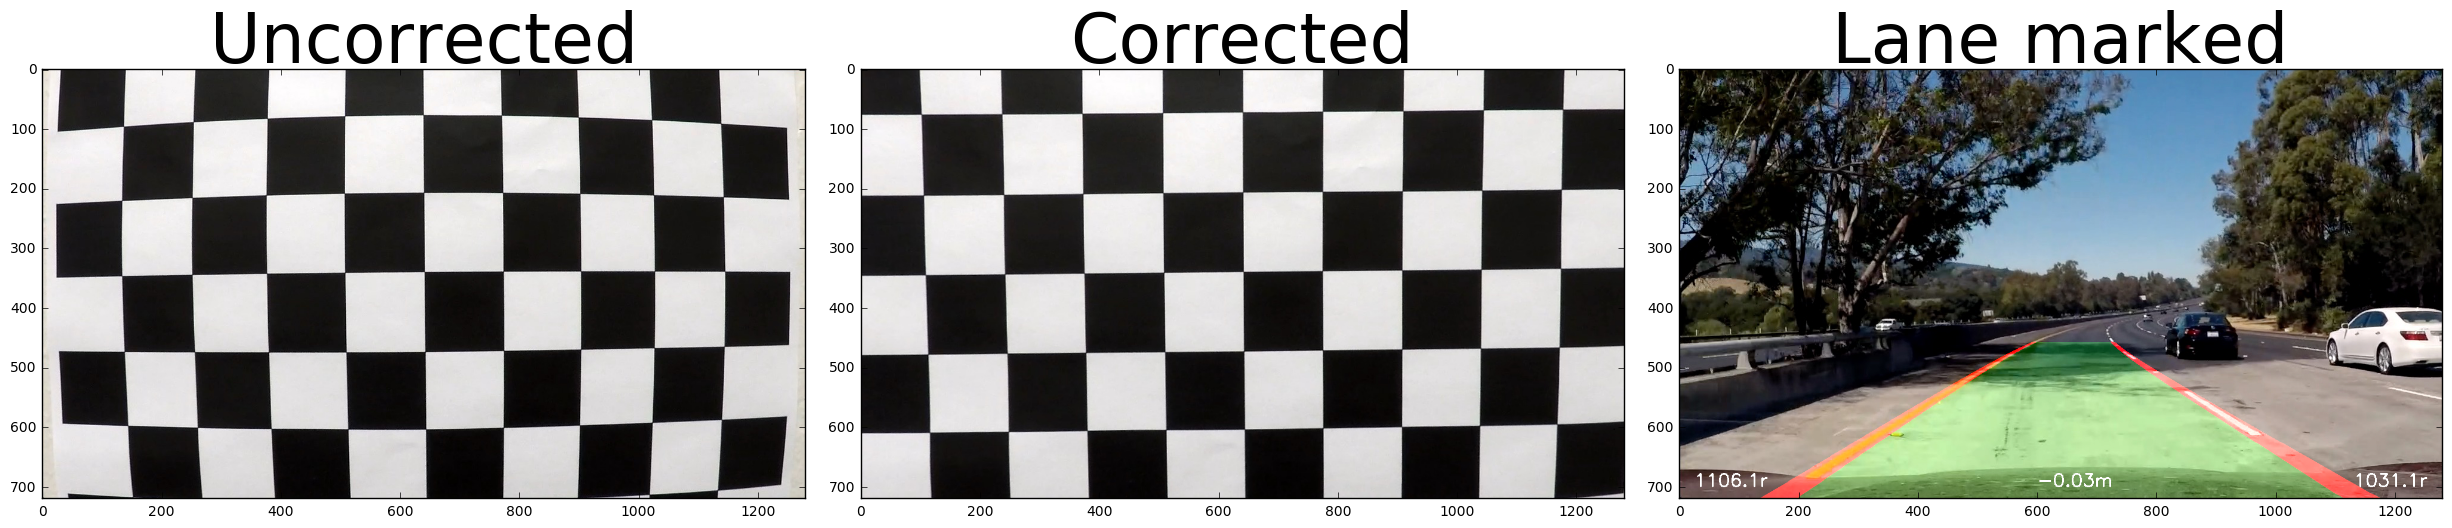

In [12]:
class StillImageSolution:
    
    def __init__(self, image_name):
        self.image_name = image_name
    
    def process_frame(self, lane_finder):
        lf = lane_finder
        
        # Load and preserve the initial (calibrated) image
        lf.load_image(self.image_name)
        original_image = lf.get_image()
        original_shape = (original_image.shape[0], original_image.shape[1])
        
        # Transform to overhead view
        lf.transform_image(camera_coordinates, birds_eye_coordinates)
        raw_transformed_image = lf.get_image()
        
        # Filter the image data
        line_data_frame = lf.filter_image(color_threshold, sobel_mag_threshold, sobel_dir_threshold)
       
        # Generate histogram and initial windowed peaks for lane lines
        h = Histogram(line_data_frame)
        peaks = h.windowed_peaks(windowed_peaks_arg[0], windowed_peaks_arg[1], histogram_valid_range, gaussian_params)
        
        # Track the left and right lane lines
        left = lf.track_lane(line_data_frame, peaks[0], vertical_track_width)
        left_r = lf.radius(left, None)
        right = lf.track_lane(line_data_frame, peaks[1], vertical_track_width)
        right_r = lf.radius(right, None)
   
        # Generate a contour image with lane and boundaries marked, transform back to car camera
        contour_image = lf.apply_contours(line_data_frame, left, right, y_range_curve_mapped, original_shape)
        lf.set_image(contour_image)
        lf.transform_image(birds_eye_coordinates, camera_coordinates)
        
        # Overlay the contour image with the original image and plot
        result = cv2.addWeighted(lf.get_image(), 1.0, original_image, 1.0, 0.0)
        
        # Overlay the left and right radii and deviation from center
        center_offset = -lane_center_scale * (np.average(peaks) - lane_center_location)
        lf.apply_text(result, left_r, right_r, center_offset)
        
        return result
    
    def run(self):
        # Create a LaneFinder with default directory and calibrate 
        lf = LaneFinder('test_images')        
        lf.calibrate(calibration_directory, calibration_geometry)
        
        # Set up an output plot
        f, (p1, p2, p3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        
        # Load a calibration image
        cal = Image()
        cal.read_file('camera_cal/calibration1.jpg')
        p1.imshow(cal.image)
        p1.set_title('Uncorrected', fontsize=50)
        
        # Run a test on the calibration visually
        cal.undistort(lf.cam_cal)
        p2.imshow(cal.image)
        p2.set_title('Corrected', fontsize=50)
        
        # Call to the frame processor
        output = self.process_frame(lf);
        
        # Display the frame
        p3.imshow(output)
        p3.set_title('Lane marked', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        
        
sis = StillImageSolution('test5.jpg')
sis.run()

In [13]:
class AveragingChecker:
    
    def __init__(self, count):
        self.data = []
        self.count = count
        
    def add(self, data):
        self.data.append(data)
        self.data = self.data[-self.count:]
       
    def average(self):
        return np.mean(self.data, axis=0)
    
    def check_with_threshold(self, data, threshold):
        average = self.average()
        diff = np.fabs(np.subtract(data, average))
        result = True
        for i, x in enumerate(diff):
            if x > threshold[i]:
                result = False
        return result
    
    def add_with_threshold_check(self, data, threshold):
        if self.check_with_threshold(data, threshold):
            self.add(data)
        return self.average()

## Vehicle Detection and Tracking Code

[ 0.99837486  0.968039    0.98293608]


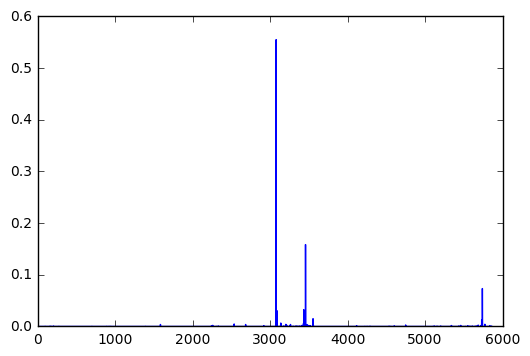

In [14]:
class Classifier:

    IMAGE_SIZE = (64, 64)
    
    SPATIAL_SIZE = (32, 32)
    
    HOG_ORIENTATIONS = 9
    HOG_PIXELS_PER_CELL = (8,8)
    HOG_CELLS_PER_BLOCK = (2,2)
    
    HLS_BINS = 512 
    HLS_BIN_RANGE = (0,255)
    
    SVC_KERNEL = 'rbf'
    SVC_C_VALUE = 2.0
    
    DT_MIN_SAMPLES_SPLIT = 40
    
    TEST_FRACTION = 0.2
    RANDOM_STATE = 12345
    
    PICKLE_FILE = 'classifier.p'
    
    def __init__(self, true_path, false_path):
        self.true_path = true_path
        self.false_path = false_path
        
    def get_recursive_paths(self, path_def):
        return glob2.glob(path_def)

    def load_image(self, filename):
        image = mpimg.imread(filename)
        return cv2.resize(image, self.IMAGE_SIZE) 

    def spatial_bins(self, image):
        return cv2.resize(image, self.SPATIAL_SIZE).ravel() 
    
    def hls_bins(self, image):
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        h_hist = np.histogram(hls[:,:,0], bins=self.HLS_BINS, range=self.HLS_BIN_RANGE)
        s_hist = np.histogram(hls[:,:,2], bins=self.HLS_BINS, range=self.HLS_BIN_RANGE)
        return np.concatenate((h_hist[0], s_hist[0]))
    
    def hog_bins(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return hog(gray, orientations=self.HOG_ORIENTATIONS, pixels_per_cell=self.HOG_PIXELS_PER_CELL, cells_per_block=self.HOG_CELLS_PER_BLOCK, transform_sqrt=True, visualise=False, feature_vector=True)
        
    def compute_spatial_hls_hog(self, image):
        spatial = self.spatial_bins(image)
        hls = self.hls_bins(image)
        hog = self.hog_bins(image)
        total = np.concatenate((spatial, hls, hog))
        #total = np.concatenate((total[250:1300], total[2300:2500], total[3100:3600]))
        return total
    
    def normalize(self, data):
        data=np.array(data, np.float32)
        self.scaler = StandardScaler().fit(data)
        scaled_data = self.scaler.transform(data)
        return scaled_data
    
    def train(self):
        self.svc_classifier = SVC(kernel=self.SVC_KERNEL,C=self.SVC_C_VALUE)
        self.svc_classifier.fit(self.training_features, self.training_labels)
        self.dt_classifier = DecisionTreeClassifier(min_samples_split=self.DT_MIN_SAMPLES_SPLIT)
        self.dt_classifier.fit(self.training_features, self.training_labels)
        return self
        
    def combine(self, list_a, list_b):
        result = []
        for idx, val_a in enumerate(list_a):
            val_b = list_b[idx]
            if val_a == 1.0 or val_b == 1.0:
                result.append(1.0)
            else:
                result.append(0.0)
        return result
        
    def test(self):
        svc_prediction = self.svc_classifier.predict(self.testing_features)
        svc_accuracy = accuracy_score(svc_prediction, self.testing_labels)
        dt_prediction = self.dt_classifier.predict(self.testing_features)
        dt_accuracy = accuracy_score(dt_prediction, self.testing_labels)
        composite_prediction = self.combine(svc_prediction, dt_prediction)
        composite_accuracy = accuracy_score(composite_prediction, self.testing_labels)
        return np.array([svc_accuracy, dt_accuracy, composite_accuracy])
        
    def classify_new(self, image):
        image = cv2.resize(image, self.IMAGE_SIZE)
        data = self.compute_spatial_hls_hog(image)
        data = self.scaler.transform(data)
        svc_prediction = self.svc_classifier.predict(data)
        dt_prediction = self.dt_classifier.predict(data)
        composite_prediction = self.combine(svc_prediction, dt_prediction)
        return np.array([svc_prediction, dt_prediction, composite_prediction])
        
    def load(self):
        features = []
        labels = []
        true_paths = self.get_recursive_paths(self.true_path)
        for filename in true_paths:
            image = self.load_image(filename)
            hls_hog = self.compute_spatial_hls_hog(image)
            features.append(hls_hog)
            labels.append(1.0)
        false_paths = self.get_recursive_paths(self.false_path) 
        for filename in false_paths:
            image = self.load_image(filename)
            hls_hog = self.compute_spatial_hls_hog(image)
            features.append(hls_hog)
            labels.append(0.0)
        features = self.normalize(features)
        self.training_features, self.testing_features, self.training_labels, self.testing_labels = train_test_split(features, labels, test_size=self.TEST_FRACTION, random_state=self.RANDOM_STATE)
        self.training_labels = np.array(self.training_labels, np.float32)
        self.testing_labels = np.array(self.testing_labels, np.float32)
        return self
    
    def save_classifier(self):
        pickle.dump(self, open(self.PICKLE_FILE, 'wb'))
        
        
classifier = Classifier('vehicles/**/*.png', 'non-vehicles/**/*.png')        
print(classifier.load().train().test())
plt.plot(classifier.dt_classifier.feature_importances_)
classifier.save_classifier()

In [15]:
class ProportionalStepScaler:
    
    def __init__(self, start_point, stop_point, start_size, stop_size, overlap):
        self.start_point = start_point
        self.stop_point = stop_point
        self.start_size = start_size
        self.stop_size = stop_size
        self.overlap = overlap
        self.size_slope = float(self.stop_size - self.start_size) / float(self.stop_point - self.start_point)
        
    def compute(self):
        result = []
        i = self.start_point + self.start_size / 2
        size = self.start_size
        while i < self.stop_point - self.stop_size / 2:
            result.append((int(i),int(size)))
            size = int(self.start_size + (i - self.start_point) * self.size_slope)
            i = int(i + size * (1 - self.overlap))
        return result
    

In [16]:
class WindowTiling:
    
    def __init__(self, image, mask_region, top_size, bottom_size, overlap):
        self.poly = Polygon(mask_region)
        roi = np.array(mask_region)
        self.image = self.region_of_interest(image, roi)
        self.top_size = top_size
        self.bottom_size = bottom_size
        self.overlap = overlap
        self.left = np.amin(roi, axis=0)[0]
        self.right = np.amax(roi, axis=0)[0]
        self.top = np.amin(roi, axis=0)[1]
        self.bottom = np.amax(roi, axis=0)[1]
        
    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        cv2.fillPoly(mask, [vertices], ignore_mask_color)
        return cv2.bitwise_and(img, mask)
  
    def vertical_enumeration(self):
        pss = ProportionalStepScaler(self.top, self.bottom, self.top_size, self.bottom_size, self.overlap) 
        return pss.compute()
        
    def horizontal_enumeration(self, size):
        pss = ProportionalStepScaler(self.left, self.right, size, size, self.overlap) 
        return pss.compute()
        
    def generate_regions(self):
        result = []
        vertical = self.vertical_enumeration()
        for v in vertical:
            horizontal = self.horizontal_enumeration(v[1])
            for h in horizontal:
                center = (h[0], v[0])
                size = (h[1], v[1])
                result.append((center, size))
        return result
    
    def generate_images(self):
        result = []
        regions = self.generate_regions()
        for r in regions:
            center = r[0]
            size = r[1]
            left = int(center[1] - size[1]/2)
            right = int(center[1] + size[1]/2)
            top = int(center[0] - size[0]/2)
            bottom = int(center[0] + size[0]/2)
            poly = ((bottom,left), (top,left), (top,right), (bottom,right))
            poly = Polygon(poly)
            intersects = poly.intersects(self.poly)
            if intersects:
                sub_image = self.image[left:right,top:bottom]
                result.append((center, size, sub_image))
        return result
    

In [17]:
class HeatMap:
    
    def __init__(self, image):
        self.image = np.array(image)
        self.height = self.image.shape[0]
        self.width = self.image.shape[1]
    
    def mono_overlay(self, points, radius, intensity):
        k_size = 3 * radius
        kernel = np.ones((k_size, k_size), np.float32) / (k_size**2)
        overlay = np.zeros((self.height, self.width), np.uint8)
        for p in points:
            p = (int(p[0]), int(p[1]))
            ol = np.zeros((self.height, self.width), np.uint8)
            cv2.circle(ol, p, radius, intensity, -1)
            ol = cv2.filter2D(ol, -1, kernel)
            cv2.addWeighted(ol, 1.0, overlay, 1.0, 0, overlay)
        return overlay
    
    def color_overlay(self, points, radius, color):
        k_size = 3 * radius
        kernel = np.ones((k_size, k_size), np.float32) / (k_size**2)
        overlay = np.zeros((self.height, self.width, 3), np.uint8)
        for p in points:
            p = (int(p[0]), int(p[1]))
            ol = np.zeros((self.height, self.width, 3), np.uint8)
            cv2.circle(ol, p, radius, color, -1)
            ol = cv2.filter2D(ol, -1, kernel)
            cv2.addWeighted(ol, 1.0, overlay, 1.0, 0, overlay)
        return overlay


In [24]:
class StillImage:
    
    MASK_REGION = ( (750,600), (750,400), (1280,400), (1280,600) )
    
    TOP_SIZE = 70
    BOTTOM_SIZE = 150  
    OVERLAP = 0.92
    
    VEHICLES = 'vehicles/**/*.png'
    NON_VEHICLES = 'non-vehicles/**/*.png'
    
    PICKLE_FILE = 'classifier.p'
    
    def load_classifier(self):
        self.classifier = pickle.load(open(self.PICKLE_FILE, 'rb'))
        
    def load_file(self, filename):
        self.image = mpimg.imread(filename)
        
    def load_image(self, image):
        self.image = image
        
    def get_image(self):
        return self.image
        
    def swap(self, data):
        return (data[1], data[0])
        
    def car_points(self):
        wt = WindowTiling(self.image, self.MASK_REGION, self.TOP_SIZE, self.BOTTOM_SIZE, self.OVERLAP)
        windows = wt.generate_images()
        points = []
        for w in windows:
            center = self.swap(w[0])
            bounds = w[1]
            ll = (int(center[0] - bounds[0] / 2), int(center[1] - bounds[1] / 2))
            ur = (int(center[0] + bounds[0] / 2), int(center[1] + bounds[1] / 2))
            corners = (ll, ur)
            image = w[2]
            is_car = self.classifier.classify_new(image)
            if is_car[2] == 1.0:
                points.append((center, corners))
        return points
    
    def get_region_centers(self, regions):
        return [self.swap(r[0]) for r in regions]
        
    def car_points_heatmap(self, radius, color):
        heat_map = HeatMap(self.image)
        points = [self.swap(r[0]) for r in self.car_points()]
        overlay = heat_map.color_overlay(points, radius, color)
        return overlay
    
    def intensity_heatmap(self, radius, intensity):
        heat_map = HeatMap(self.image)
        points = [self.swap(r[0]) for r in self.car_points()]
        overlay = heat_map.mono_overlay(points, radius, intensity)
        return overlay
    
    def overlay(self, image, alpha):
        cv2.addWeighted(image, alpha, self.image, 1.0, 0, self.image)
        return self.image
        

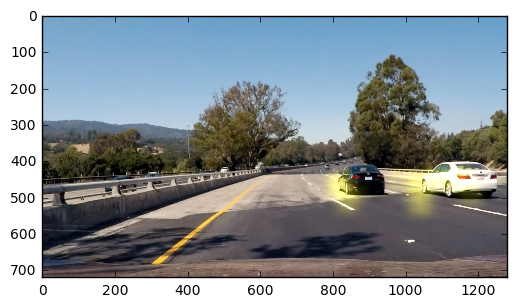

In [25]:
si = StillImage()
si.load_classifier()
si.load_file('test_images/test4.jpg')
cp = si.car_points_heatmap(20, (100,100,0))
plt.imshow(si.overlay(cp, 1.0))

In [26]:
class OverlayFrameCombiner:
    
    def __init__(self, num_frames, height, width):
        self.num_frames = num_frames
        self.frames = []
        self.height = height
        self.width = width
        
    def add_frame(self, frame):
        self.frames.append(frame)
        self.frames = self.frames[-self.num_frames:]

    def rectangles(self, min_bound, min_area, rect_limit):
        centers = []
        bounding_boxes = []
        image = np.zeros((self.height, self.width, 3), np.uint8)
        combined = np.zeros((self.height, self.width), np.uint8)
        for f in self.frames:
            cv2.addWeighted(f, 1.0, combined, 1.0, 0, combined)
        threshold = cv2.threshold(combined, min_bound, 255, cv2.THRESH_BINARY)
        contours = cv2.findContours(threshold[1].copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours[1], key=cv2.contourArea, reverse=True)
        for c in contours:
            area = cv2.contourArea(c)
            if area > min_area:
                bb = cv2.boundingRect(c)
                center = (bb[0] + bb[2] / 2, bb[1] + bb[3] / 2)
                centers.append(center)
                bounding_boxes.append(bb)
        return (centers[:rect_limit], bounding_boxes[:rect_limit])
    
    def rectangle_overlay(self, image, bounding_boxes, color):
        overlay = np.zeros((self.height, self.width, 3), np.uint8)
        for bb in bounding_boxes:
            cv2.rectangle(overlay, (bb[0], bb[1]), (bb[0] + bb[2], bb[1] + bb[3]), color, 3)
        return overlay

In [45]:
class PointTracker:
    
    TOTAL_POINTS = 30
    IS_VALID_POINTS = 15
    IS_SHOWN_POINTS = 15
    
    def __init__(self, center):
        self.updated = True
        self.centers = [center]
   
    def reset_update(self):
        self.updated = False

    def update(self, center):
        self.centers.append(center)
        self.centers = self.centers[-self.TOTAL_POINTS:]
        self.updated = True
        
    def is_valid(self):
        if self.centers.count(None) > self.IS_VALID_POINTS:
            return False
        else:
            return True
    
    def is_shown(self):
        if len(self.centers) - self.centers.count(None) > self.IS_SHOWN_POINTS:
            return True
        else:
            return False
    
    def center_average(self):
        total = len(self.centers) - self.centers.count(None)
        total_x = 0
        total_y = 0
        for c in self.centers:
            if c != None:
                total_x += c[0]
                total_y += c[1]
        return (int(total_x / total), int(total_y / total))
    
    
class ObjectTracker:
    
    def __init__(self, distance):
        self.objects = []
        self.distance = distance
        
    def is_close(self, a, b):
        dx = a[0] - b[0]
        dy = a[1] - b[1]
        d = math.sqrt(dx**2 + dy**2)
        if d < self.distance:
            return True
        else:
            return False
        
    def new_data(self, rectangles):
        rect = rectangles
        for p in self.objects:
            p.reset_update()
        for r in list(rect):
            for o in self.objects:
                if self.is_close(r, o.center_average()) and o.updated == False:
                    o.update(r)
                    rect.remove(r)
        for r in rect:
            self.objects.append(PointTracker(r))
        for o in self.objects:
            if o.updated == False:
                o.update(None)
        new_objects = []
        for o in self.objects:
            if o.is_valid():
                new_objects.append(o)
        self.objects = new_objects
        result = []
        for o in self.objects:
            if o.is_shown():
                result.append(o.center_average())
        return result


In [28]:
class FilteredCentroidBoundingBox:
    
    MASK_REGION = ( (750,600), (750,400), (1280,400), (1280,600) )
    
    LOW_COLOR = (0,0,0)
    HIGH_COLOR = (255,255,255)
    
    THRESHOLD_MIN = 50
    THRESHOLD_MAX = 255
    
    LOW_PERCENTILE = 90
    HIGH_PERCENTILE = 95
    
    def __init__(self, image):
        self.image = image
        self.compute_image = image
        
    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        cv2.fillPoly(mask, [np.array(vertices)], ignore_mask_color)
        return cv2.bitwise_and(img, mask)

    def select_colors(self, low_value, high_value):
        mask = cv2.inRange(self.compute_image, low_value, high_value)
        self.compute_image = cv2.bitwise_and(self.compute_image, self.compute_image, mask=mask)
    
    def select_mask_region(self, region):
        self.compute_image = self.region_of_interest(self.compute_image, region)
    
    def mutate_colorspace(self):
        hls = cv2.cvtColor(self.compute_image, cv2.COLOR_RGB2HLS)
        s = hls[:,:,2]
        self.compute_image = s
        
    def select_region(self, region):
        self.compute_image = self.compute_image[region[0][0]:region[0][1],region[1][0]:region[1][1]]
    
    def scale_and_threshold(self, threshold_min, theshold_max):
        scale = np.max(self.compute_image) / 255.0
        self.compute_image = (self.compute_image / scale).astype(np.uint8)
        _, self.compute_image = cv2.threshold(self.compute_image, threshold_min, theshold_max, cv2.THRESH_BINARY)
    
    def compute_centroid(self):
        m = cv2.moments(self.compute_image)
        x = int(m["m10"] / m["m00"])
        y = int(m["m01"] / m["m00"])
        return (x, y)
    
    def compute_weighted_marginal(self, axis):
        data = np.sum(self.compute_image, axis=axis) / 255
        data = np.sort(data)
        length = len(data)
        low = int(length * (self.LOW_PERCENTILE - 100) / 100)
        high = int(length * (self.HIGH_PERCENTILE - 100) / 100)
        data = data[low:high]
        return np.average(data)
    
    def get_bbox(self, center_estimate, bounds):
        self.select_colors(self.LOW_COLOR, self.HIGH_COLOR)
        self.select_mask_region(self.MASK_REGION)
        self.mutate_colorspace()
        x_range = (center_estimate[0] - bounds[0], center_estimate[0] + bounds[0])
        y_range = (center_estimate[1] - bounds[1], center_estimate[1] + bounds[1])
        region = (x_range, y_range)
        self.select_region(region)
        self.scale_and_threshold(self.THRESHOLD_MIN, self.THRESHOLD_MAX)
        center = self.compute_centroid()
        x = self.compute_weighted_marginal(1)
        y = self.compute_weighted_marginal(0)
        x1 = int(center[0] - x / 2 + center_estimate[1] - bounds[0])
        x2 = int(center[0] + x / 2 + center_estimate[1] - bounds[0])
        y1 = int(center[1] - y / 2 + center_estimate[0] - bounds[1])
        y2 = int(center[1] + y / 2 + center_estimate[0] - bounds[1])
        return (x1,y1,x2-x1,y2-y1)
 

## Code For Running the Ensemble

In [46]:
class LaneLinesAndDetection:
    
    FRAME_WIDTH = 1280
    FRAME_HEIGHT = 720
    
    OVERLAY_FRAMES = 7
    
    PLOT_HEATMAP_COLOR = (100,100,0)
    PLOT_HEATMAP_SIZE = 20
    
    COMPUTE_HEATMAP_INTENSITY = 20
    COMPUTE_HEATMAP_SIZE = 35
    
    RECTANGLE_LIMIT = 2
    RECTANGLE_MIN_INTENSITY = 60
    RECTANGLE_MIN_AREA = 7000
    
    BOUNDING_BOX_COLOR = (255,0,0)
    
    OBJECT_TRACKER_DISTANCE = 100
    
    HEATMAP_ALPHA = 0.4
    
    INITIAL_BOUNDS = (100,100)
    
    def __init__(self, input_video_name, output_video_name):
        self.input_video_name = input_video_name
        self.output_video_name = output_video_name
        self.si = StillImage()
        self.si.load_classifier()
        self.ofc = OverlayFrameCombiner(self.OVERLAY_FRAMES, self.FRAME_HEIGHT, self.FRAME_WIDTH)
        self.ot = ObjectTracker(self.OBJECT_TRACKER_DISTANCE)
    
    def process_frame_lane(self, frame, lane_finder, initialization):
        lf = lane_finder
        
        # Load and preserve the initial (calibrated) image
        image = Image()
        image.set_image(frame)
        lf.set_video_image(image)
        if hasattr(lf.image, 'caml_cal'):
            lf.image.undistort(lf.cam_cal)
        original_image = lf.get_image()
        original_shape = (original_image.shape[0], original_image.shape[1])
        
        # Transform to overhead view
        lf.transform_image(camera_coordinates, birds_eye_coordinates)
        raw_transformed_image = lf.get_image()
        
        # Filter the image data
        line_data_frame = lf.filter_image(color_threshold, sobel_mag_threshold, sobel_dir_threshold)
      
        # Generate histogram and initial windowed peaks for lane lines
        h = Histogram(line_data_frame)
        peaks = h.windowed_peaks(windowed_peaks_arg[0], windowed_peaks_arg[1], histogram_valid_range, gaussian_params)
        
        # Track the left and right lane lines
        left = lf.track_lane(line_data_frame, peaks[0], vertical_track_width)
        try:
            left_r = lf.radius(left, 'left')
        except:
            left_r = float('nan')
        right = lf.track_lane(line_data_frame, peaks[1], vertical_track_width)
        try:
            right_r = lf.radius(right, 'right')
        except:
            right_r = float('nan')
   
        # Conditionally update the fits and procede with fill application on images
        if initialization == True:
            self.left_ac.add(lf.left_fit)
            self.right_ac.add(lf.right_fit)
            return None
        
        else:
            lf.left_fit = self.left_ac.add_with_threshold_check(lf.left_fit, curve_threshold)
            lf.right_fit = self.right_ac.add_with_threshold_check(lf.right_fit, curve_threshold)
            
            # Generate a contour image with lane and boundaries marked, transform back to car camera
            contour_image = lf.apply_contours_video(line_data_frame, lf.left_fit, lf.right_fit, y_range_curve_mapped, original_shape)
            lf.set_image(contour_image)
            lf.transform_image(birds_eye_coordinates, camera_coordinates)
        
            # Overlay the contour image with the original image and plot
            result = cv2.addWeighted(lf.get_image(), 1.0, original_image, 1.0, 0.0)
        
            # Overlay the left and right radii and deviation from center
            center_offset = -lane_center_scale * (np.average(peaks) - lane_center_location)
            lf.apply_text(result, left_r, right_r, center_offset)
        
            return (original_image, result)
        
    def process_frame_detection(self, frame):
        self.si.load_image(frame)
        car_points_heatmap = self.si.car_points_heatmap(self.PLOT_HEATMAP_SIZE, self.PLOT_HEATMAP_COLOR)
        intensity_heatmap = self.si.intensity_heatmap(self.COMPUTE_HEATMAP_SIZE, self.COMPUTE_HEATMAP_INTENSITY)
        self.ofc.add_frame(intensity_heatmap)
        rectangles = self.ofc.rectangles(self.RECTANGLE_MIN_INTENSITY, self.RECTANGLE_MIN_AREA, self.RECTANGLE_LIMIT)
        centers = self.ot.new_data(rectangles[0])
        rect = []
        for c in centers:
            fcbb = FilteredCentroidBoundingBox(frame)
            bb = fcbb.get_bbox((c[1],c[0]), self.INITIAL_BOUNDS)
            rect.append(bb)
        rectangles = self.ofc.rectangle_overlay(frame, rect, self.BOUNDING_BOX_COLOR)
        return (car_points_heatmap, rectangles)
       
    def run(self, averaging_frames):
        # Create a LaneFinder with default directory and calibrate 
        lf = LaneFinder('test_videos')        
        lf.calibrate(calibration_directory, calibration_geometry)
        
        # Load the video
        video = VideoFileClip(lf.test_image_folder + '/' + self.input_video_name)
        
        # Create a new AveragingChecker for the left and right lane lines
        self.left_ac = AveragingChecker(averaging_frames)
        self.right_ac = AveragingChecker(averaging_frames)
        
        # Iterate over the frames, dispatching to the frame processor
        output_frames = []
        for i, frame in tqdm.tqdm(enumerate(video.iter_frames())):
            if i < averaging_frames:
                self.process_frame_lane(frame, lf, True)
            else:
                (undistorted_image, lane_frame) = self.process_frame_lane(frame, lf, False)
                (heat_map_image, rectangles_image) = self.process_frame_detection(undistorted_image)
                cv2.addWeighted(heat_map_image, self.HEATMAP_ALPHA, lane_frame, 1.0, 0, lane_frame)
                cv2.addWeighted(rectangles_image, 1.0, lane_frame, 1.0, 0, lane_frame)
                output_frames.append(lane_frame)

        # Create the resulting video
        new_video = ImageSequenceClip(output_frames, fps=video.fps)
        
        # Write video to disk
        new_video.write_videofile(lf.test_image_folder + '/' + self.output_video_name, audio=False)
        
        
        
lld = LaneLinesAndDetection('project_video.mp4', 'project_video_output_combined.mp4')
lld.run(video_average_frames)

340it [59:05, 10.39s/it]


KeyboardInterrupt: 